In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../Data/RestaurantVisitors.csv', index_col='date', parse_dates=True)
df.index.freq = 'D'
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [4]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [5]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [7]:
len(df), len(df1), len(df1) - len(df)

(517, 478, -39)

In [9]:
df1['total'] = df1['total'].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98


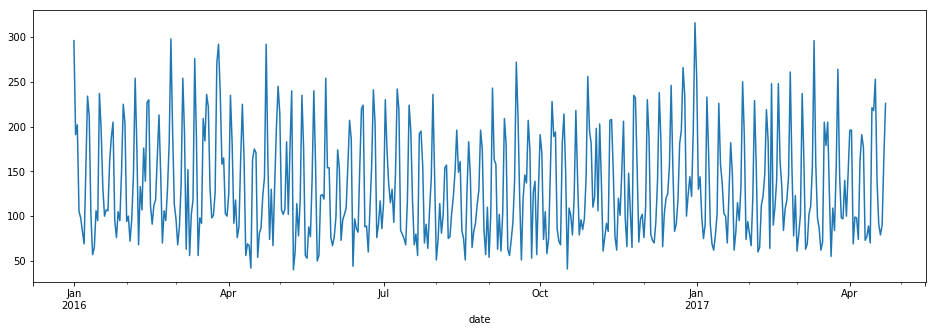

In [10]:
df1['total'].plot(figsize=(16, 5))

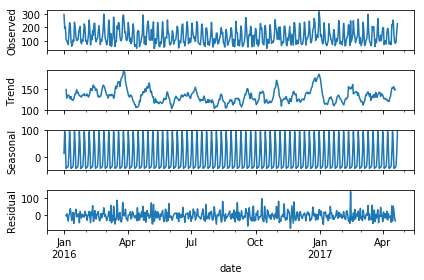

In [11]:
# ETS Decomposition
result = seasonal_decompose(df1['total'])
result.plot();

In [12]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### SARIMA

In [14]:
auto_arima(df1['total'], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Sun, 28 Aug 2022   AIC                           4845.442
Time:                                   19:22:32   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5662      4.363      4.714      0.000      12.015      29.118
ar.L1          0.1897      0.045      4.221      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.3967     86.679     16.468      0.000    1257.510    1597.283
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
train = df1.iloc[:436]
test = df1.iloc[436:]

In [16]:
model = SARIMAX(train['total'], order=(1,0,0), seasonal_order=(2,0,0,7), enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Sun, 28 Aug 2022   AIC                           4457.403
Time:                                   19:25:56   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
start = len(train)
end = start + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

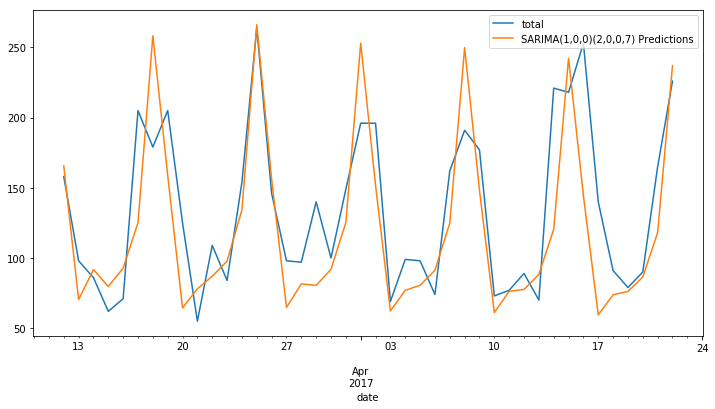

In [18]:
test['total'].plot(figsize=(12, 6), legend=True)
predictions.plot(legend=True)

In [19]:
# Evaluate Model
from statsmodels.tools.eval_measures import rmse, mse

mse_error = mse(test['total'], predictions)
rmse_error = rmse(test['total'], predictions)

print(f'mse error: {round(mse_error, 3)}')
print(f'rmse error: {round(rmse_error, 3)}')

mse error: 1702.648
rmse error: 41.263


#### SARIMAX

In [20]:
model = SARIMAX(train['total'], exog=train['holiday'], order=(1,0,0), seasonal_order=(2,0,0,7), enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Sun, 28 Aug 2022   AIC                           4326.963
Time:                                   19:35:52   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8887      4.241     15.774      0.000      58.577      75.200
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.312      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.3953     73.301     15.244      0.000     973.727    1261.063
===================================================================================
Ljung-Box (Q):                      100.96   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
start = len(train)
end = start + len(test) - 1
exog_forecast = test[['holiday']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

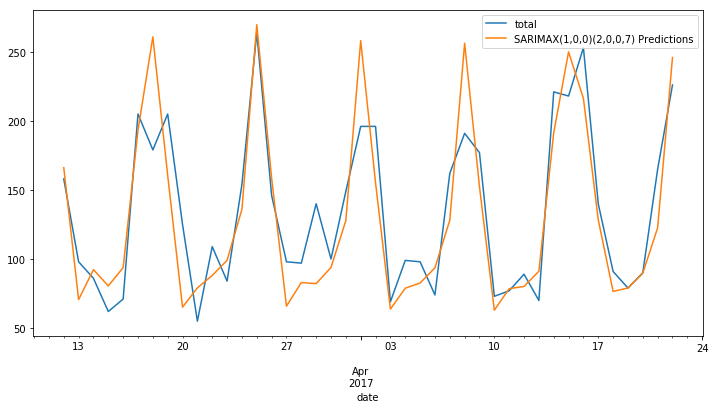

In [22]:
test['total'].plot(figsize=(12, 6), legend=True)
predictions.plot(legend=True)

In [23]:
mse_error = mse(test['total'], predictions)
rmse_error = rmse(test['total'], predictions)

print(f'mse error: {round(mse_error, 3)}')
print(f'rmse error: {round(rmse_error, 3)}')

mse error: 950.669
rmse error: 30.833


#### Forecast on full data

In [24]:
model = SARIMAX(df1['total'], exog=df1['holiday'], order=(1,0,0), seasonal_order=(2,0,0,7), enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
forecast = results.predict(len(df1), len(df1)+38, exog=exog_forecast).rename('SARIMX(1,0,0)(2,0,0,7) FORECAST')

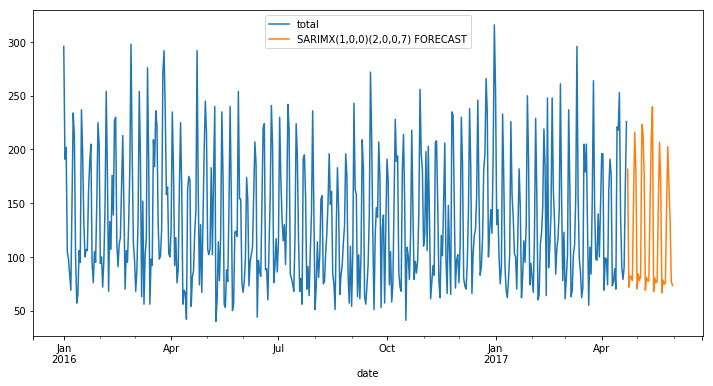

In [25]:
df1['total'].plot(figsize=(12, 6), legend=True)
forecast.plot(legend=True)